In [1]:
import os
import torch
# import GPUtil
import torchvision
from torch.utils.data import random_split
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

torch.cuda.empty_cache()
# Loading training data
dataset = ImageFolder('./Holes+Tunnels_DataSet/', transform=ToTensor())

img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 60, 80]) 0


tensor([[[0.2549, 0.2627, 0.2941,  ..., 0.7569, 0.7647, 0.7490],
         [0.2510, 0.2784, 0.3020,  ..., 0.7608, 0.7686, 0.7529],
         [0.2588, 0.2784, 0.3216,  ..., 0.7647, 0.7686, 0.7569],
         ...,
         [0.3569, 0.4078, 0.3882,  ..., 0.2941, 0.3020, 0.3020],
         [0.3098, 0.2941, 0.2980,  ..., 0.3412, 0.3569, 0.3647],
         [0.3922, 0.3725, 0.4549,  ..., 0.4078, 0.4157, 0.4196]],

        [[0.2510, 0.2510, 0.2745,  ..., 0.7412, 0.7490, 0.7333],
         [0.2549, 0.2667, 0.2902,  ..., 0.7451, 0.7529, 0.7373],
         [0.2627, 0.2667, 0.3020,  ..., 0.7490, 0.7529, 0.7412],
         ...,
         [0.3922, 0.4235, 0.3882,  ..., 0.2941, 0.2980, 0.2980],
         [0.3490, 0.3137, 0.3020,  ..., 0.3412, 0.3529, 0.3608],
         [0.4392, 0.3922, 0.4588,  ..., 0.4078, 0.4118, 0.4157]],

        [[0.1804, 0.2157, 0.2588,  ..., 0.6941, 0.7020, 0.6863],
         [0.1843, 0.2314, 0.2706,  ..., 0.6980, 0.7059, 0.6902],
         [0.1922, 0.2314, 0.2863,  ..., 0.7020, 0.7059, 0.

Label:  Holes (0)


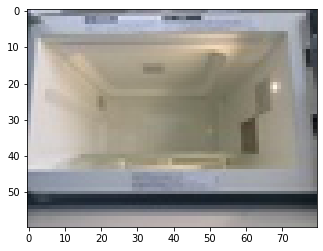

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# view the image and change tensor values to (200, 200, 3)

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
show_example(*dataset[5]) # display image and its label

In [3]:
random_seed = 40
torch.manual_seed(random_seed)

val_size = 27
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(247, 27)

In [4]:
from torch.utils.data.dataloader import DataLoader

# create data loaders for training and validation, to load the data in batches

batch_size=50
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

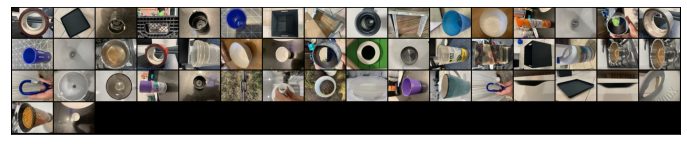

In [5]:
from torchvision.utils import make_grid

# View batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define model

simple_model = nn.Sequential(
    nn.Conv2d( 3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)


In [7]:
# extend an ImageClassificationBase class which contains helper methods for training & validation

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
# use nn.Sequential to chain the layers and activations functions into a single network architecture

class Hydride(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 100, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(100, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(),
            nn.Linear(3000, 3)  #dont change
        )
    
    def forward(self, xb):
        return self.network(xb)

In [11]:
model = Hydride()

In [12]:
# training model
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
model = Hydride()
evaluate(model, val_dl)

{'val_loss': 1.09999680519104, 'val_acc': 0.2222222238779068}

In [14]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [18]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.8185, val_loss: 0.7783, val_acc: 0.5926
Epoch [1], train_loss: 0.7737, val_loss: 0.7457, val_acc: 0.5926
Epoch [2], train_loss: 0.7186, val_loss: 0.7442, val_acc: 0.5926
Epoch [3], train_loss: 0.7136, val_loss: 0.7183, val_acc: 0.6667
Epoch [4], train_loss: 0.6742, val_loss: 0.6965, val_acc: 0.6667
Epoch [5], train_loss: 0.6264, val_loss: 0.7306, val_acc: 0.7037
Epoch [6], train_loss: 0.6123, val_loss: 0.6822, val_acc: 0.7407
Epoch [7], train_loss: 0.5335, val_loss: 0.6871, val_acc: 0.7407
Epoch [8], train_loss: 0.4839, val_loss: 0.8078, val_acc: 0.7407
Epoch [9], train_loss: 0.4207, val_loss: 0.6973, val_acc: 0.7037


In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

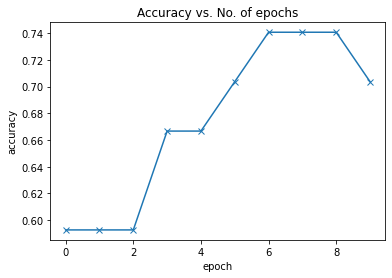

In [22]:
plot_accuracies(history)

In [85]:
#display comparisons
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

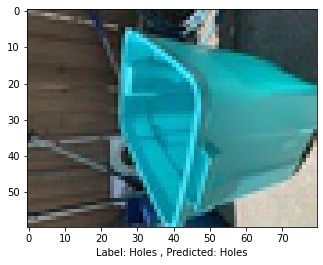

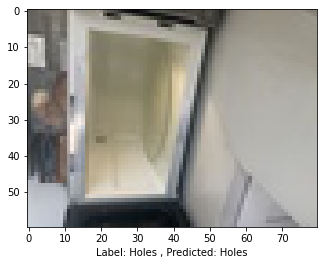

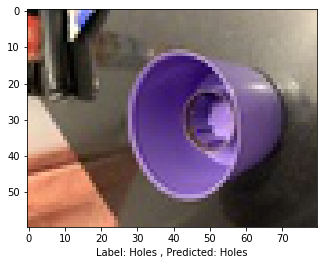

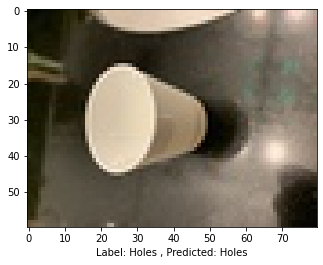

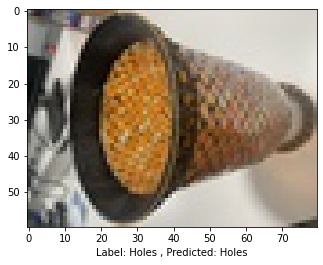

In [96]:
# Holes 
import random

for i in range(0, 5): # range(x, n) is from x to (n-1)
    randomIndex = random.randint(0, 168)
    img, label = dataset[randomIndex]
    xLabel = 'Label: ' + dataset.classes[label] + ' , Predicted: ' + predict_image(img, model)
    plt.figure()
    plt.xlabel(xLabel)
    plt.imshow(img.permute(1, 2, 0))

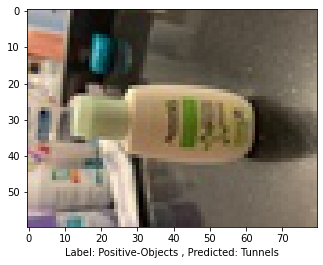

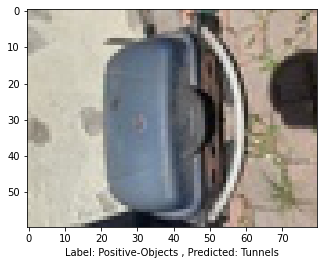

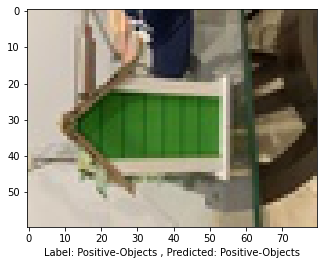

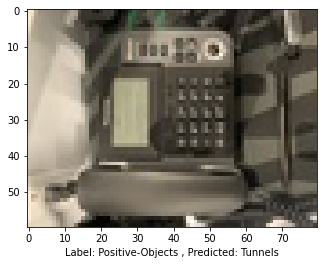

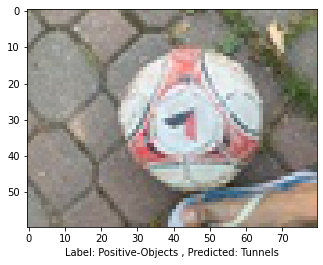

In [100]:
# Positive Objects

for i in range(0, 5): # range(x, n) is from x to (n-1)
    randomIndex = random.randint(169, 185)
    img, label = dataset[randomIndex]
    xLabel = 'Label: ' + dataset.classes[label] + ' , Predicted: ' + predict_image(img, model)
    plt.figure()
    plt.xlabel(xLabel)
    plt.imshow(img.permute(1, 2, 0))

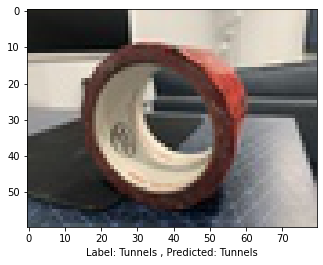

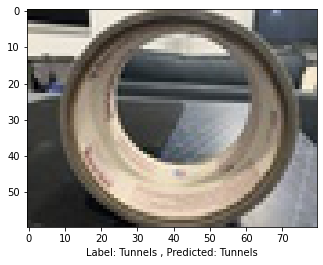

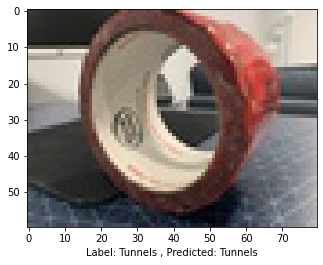

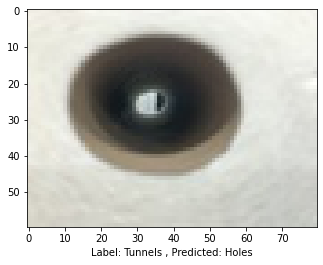

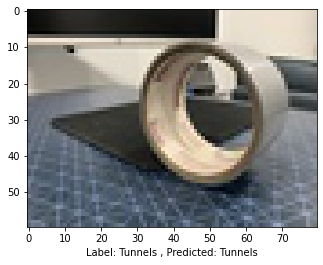

In [103]:
# Tunnels 
    
for i in range(0, 5): # range(x, n) is from x to (n-1)
    randomIndex = random.randint(186, 204)
    img, label = dataset[randomIndex]
    xLabel = 'Label: ' + dataset.classes[label] + ' , Predicted: ' + predict_image(img, model)
    plt.figure()
    plt.xlabel(xLabel)
    plt.imshow(img.permute(1, 2, 0))